<a href="https://colab.research.google.com/github/vhoma/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [1]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=98cfb4056e82b68e1ef30bf2c3709c469cb8c215c43001dcf51cd08ee0b0112e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Cloning https://github.com/pydicom/pydicom.git to /tmp/pip-req-build-okvt9h8g
  Running command git clone -q https://github.com/pydicom/pydicom.git /tmp/pip-req-build-okvt9h8g
  Created wheel for pydicom: filename=pydicom-2.4.0.dev0-py3-none-any.whl size=1966307 sha256=17f8ad953d2427e7ea96e0fc3e0d228ff814a3960c3d2f365a91a15c6fffc707
  Stored in directory: /tmp/pip-ephem-wheel-cache-n3y7tvnw/wheels/8a/75/6f/a3a81ff6d9eaa04f50d99238b899485b32c5948527a33b243c
Successfully built pydicom
     |████████████████████████████████| 12.6 MB 5.3 MB/s 


In [2]:
import dicom_utils as dcm
import Affine3D as affine
from scipy.ndimage import affine_transform

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [3]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")
#data_path = os.path.join(home_path, "data")
#print(data_path)

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import copy

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [ ]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

### Variant 1 (concatenating the input)

In [ ]:
class Our_AirNet(nn.Module):
    def __init__(self):
        super(Our_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))    
        
    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition(inp) #80
        inp = self.transition(inp) #40
        inp = self.transition(inp) #20
        input_conc = torch.cat((inp[:inp.shape[0]].flatten(),inp[inp.shape[0]:].flatten()),dim=0)
        #inp = self.flatten(inp)
        res = self.regression(input_conc)
        return res        



In [ ]:
model = Our_AirNet()
summary(model, (20, 320, 320), batch_size=1)

TypeError: ignored

In [ ]:

a = torch.rand(1,3,5,5) # input a
print(a.shape)
b = torch.rand(1,3,5,5) # input b
print(b.shape)
c = torch.cat((a,b),dim=0) # stack them batch-wise
n=a.shape[0]
c.shape

d = torch.cat((c[:a.shape[0]].flatten(),c[a.shape[0]:].flatten()),dim=0)
d.shape
#print(input_conc)
c[:a.shape[0]].shape

a = a.flatten()
a.shape
b = b.flatten()
c.shape
c = torch.cat((a,b), dim=0)


torch.Size([150])

#Dataset creation (dataloader)

In [8]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)

def transform(img):
    alpha = np.random.randint(-45, 45)
    m = affine.Affine3dRotateCenterMatrix(alpha, img.shape, axis=2)
    return affine.affine_transform(img, m), m

class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))
        
    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)
        label, matrix = transform(img3d)
        print(label.shape, matrix.shape)
        matrix = matrix[:3,:]
        print(matrix)
        #label = label.transpose(2, 0, 1)
        label = np.expand_dims(label, axis=0)
        label = torch.from_numpy(label).float()
        #adding this to get the dimensions nedded
        #img3d = img3d.transpose(2, 0, 1)
        img3d = np.expand_dims(img3d, axis=0)
        #print(img3d.shape , label.shape)
        item = torch.from_numpy(img3d).float()
        return item, label, matrix
    
    def __len__(self):
        return len(self.names_array)

In [6]:
dataset = Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
%%time
x, y, matrix = next(iter(dataloader))

(320, 320, 20) (4, 4)
[[  0.9135454    0.40673664   0.         -51.245132  ]
 [ -0.40673664   0.9135454    0.          78.91059   ]
 [  0.           0.           1.           0.        ]]
CPU times: user 799 ms, sys: 16.4 ms, total: 816 ms
Wall time: 1.23 s


In [9]:
x.shape, y.shape, matrix.shape

(torch.Size([1, 1, 320, 320, 20]),
 torch.Size([1, 1, 320, 320, 20]),
 torch.Size([1, 3, 4]))

In [ ]:
a = x[:,:,:,:,0]
a.shape
b = x[0,0,0,0,:]
b.shape

torch.Size([20])

In [ ]:
matrix1 = matrix[:,:3,:]

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

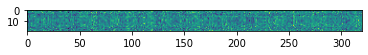

In [ ]:
plt.imshow(x[0][:,:,10])

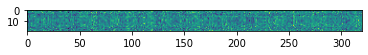

In [ ]:
plt.imshow(y[0][:,:,10])

#Running model

In [ ]:
model = Our_AirNet()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 200

tensor([-0.0197, -0.0797,  0.1377, -0.0994, -0.1377,  0.0629, -0.1616, -0.0213,
        -0.0516, -0.0484, -0.0212,  0.0324], grad_fn=<AddBackward0>)
Epoch number 0
 Current loss 8136.6103515625

tensor([ 11.9359,   3.3203,  -2.5078, -31.7990, -15.8976,   0.6551,  -3.3834,
         21.7940, -20.3648,   3.9523,   9.3008,   4.2446],
       grad_fn=<AddBackward0>)
Epoch number 1
 Current loss 4085.4814453125

tensor([  3.6970,  39.7503,  40.8980, -97.5749, -16.2177,   8.3973,  11.8941,
        119.4161,  -4.0638,  34.6746,  14.6565,  20.5105],
       grad_fn=<AddBackward0>)
Epoch number 2
 Current loss 9737.9326171875

tensor([ -4.5751,  -4.9232,  13.2321, -20.8142,   4.8933,   1.2741,  -4.0398,
         27.9834,   6.6516,  -2.3142,  -1.1609,   0.1209],
       grad_fn=<AddBackward0>)
Epoch number 3
 Current loss 3405.048828125

tensor([ -0.4917, -14.2000,   4.0030, -14.7608,   2.3570,   3.3337,  -9.2449,
         21.2997,   0.4978, -10.6680,  -0.7257,  -2.4934],
       grad_fn=<AddBackward

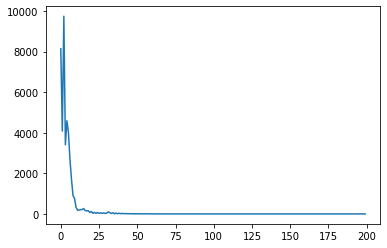

<All keys matched successfully>

In [ ]:
best_loss = np.inf
loss_history = [] 
best_model_wts = copy.deepcopy(model.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model(x, y)
        #print(res.shape)
        print(res)
        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts = copy.deepcopy(model.state_dict())

        loss_history.append(loss.item())



print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model.load_state_dict(best_model_wts)
#y.shape

the input
the output of the model


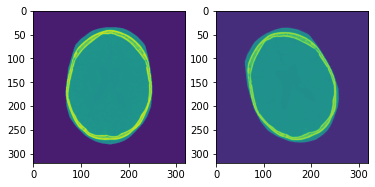

In [ ]:
#Printing the initial input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])





the output of the model
Final MSE error: 3.695887684784793e-08
Let us compare label and output of the model (we will apply resulting natrix on x_input)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 4])) that is different to the input size (torch.Size([1, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


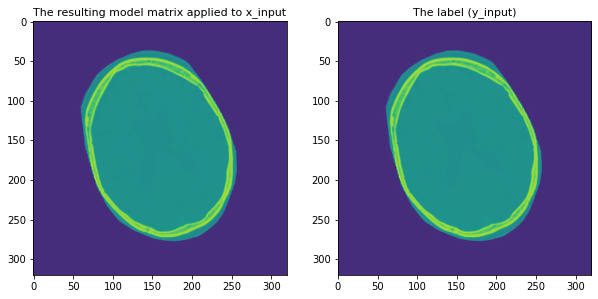

In [ ]:
print('the output of the model')
#model.load_state_dict(best_model_wts)
matrix_output = model(x, y)

#matrix_output = torch.tensor([ 9.2041e-01,  3.9060e-01, -4.6968e-05, -4.9798e+01, -3.9079e-01,
 #        9.2044e-01,  9.8165e-05,  7.5236e+01,  5.0508e-05, -1.2242e-04,
  #       9.9987e-01, -2.5560e-04], requires_grad=False)
matrix_output = matrix_output.reshape(3,4)
mse=nn.MSELoss()
print(f'Final MSE error: {mse(matrix, matrix_output)}')

matrix_output = matrix_output.detach().numpy()
print('Let us compare label and output of the model (we will apply resulting natrix on x_input)')
fig = plt.subplots(1,2, figsize=(10, 5))
plt.subplot(1,2,1)
y_new = affine_transform(x_to_print, matrix_output)
plt.title('The resulting model matrix applied to x_input',fontdict={'fontsize':11})
plt.imshow(y_new[:,:,10])
plt.subplot(1,2,2)
plt.title('The label (y_input)', fontdict={'fontsize':11})
plt.imshow(y_to_print[:,:,10])
plt.show()

###Variant2 (Siamese network)

In [ ]:
'''
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)
'''        

In [ ]:
'''
class Dense_Block(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block, self).__init__()
    self.relu = nn.ReLU(inplace = True)
    self.bn = nn.BatchNorm2d(num_channels = in_channels)
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
    bn = self.bn(x) 
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
   
    conv4 = self.relu(self.conv4(c3_dense)) 
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
   
    conv5 = self.relu(self.conv5(c4_dense))
    c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
   
    return c5_dense




class Dense_Block(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block, self).__init__()
    self.relu = nn.ReLU(inplace = True)
    self.bn = nn.BatchNorm2d(num_channels = in_channels)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

def forward(self, x):
    bn = self.bn(x)
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
   
    conv4 = self.relu(self.conv4(c3_dense)) 
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
   
    conv5 = self.relu(self.conv5(c4_dense))
    c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
   
    return c5_dense

class Transition_Layer(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer, self).__init__() 
    
    self.relu = nn.ReLU(inplace = True) 
    self.bn = nn.BatchNorm2d(num_features = out_channels) 
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False) 
    self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0) 

  def forward(self, x): 
    bn = self.bn(self.relu(self.conv(x))) 
    out = self.avg_pool(bn) 
    return out 

class DenseNet(nn.Module): 
  def __init__(self, nr_classes): 
    super(DenseNet, self).__init__() 
  
    self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False) 
    self.relu = nn.ReLU()
    
    # Make Dense Blocks 
    self.denseblock1 = self._make_dense_block(Dense_Block, 64) 
    self.denseblock2 = self._make_dense_block(Dense_Block, 128)
    self.denseblock3 = self._make_dense_block(Dense_Block, 128)
    # Make transition Layers 
    self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
    self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
    self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)
    # Classifier 
    self.bn = nn.BatchNorm2d(num_features = 64) 
    self.pre_classifier = nn.Linear(64*4*4, 512) 
    self.classifier = nn.Linear(512, nr_classes)
 
  def _make_dense_block(self, block, in_channels): 
    layers = [] 
    layers.append(block(in_channels)) 
    return nn.Sequential(*layers) 

  def _make_transition_layer(self, layer, in_channels, out_channels): 
    modules = [] 
    modules.append(layer(in_channels, out_channels)) 
    return nn.Sequential(*modules) 

  def forward(self, x): 
    out = self.relu(self.lowconv(x)) 
    out = self.denseblock1(out) 
    out = self.transitionLayer1(out) 
    out = self.denseblock2(out) 
    out = self.transitionLayer2(out) 
    
    out = self.denseblock3(out) 
    out = self.transitionLayer3(out) 
 
    out = self.bn(out) 
    out = out.view(-1, 64*4*4) 
    
    out = self.pre_classifier(out) 
    out = self.classifier(out)
    return out    

'''

### Last code version

In [22]:
class Dense_Block2d1(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block2d1, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

  #I concatenated here conv1 with the input - to check if it is correct to use x after BN, or after RELU? or just x?
  def forward(self, x):
      bn = self.bn(x) #to check the order of BatchNorm and Conv
      conv1 = self.relu(self.conv1(bn))
      c1_dense = self.relu(torch.cat([self.relu(bn), conv1], 1))    
      return c1_dense

class Dense_Block2d2(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block2d2, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
    bn = self.bn(x) #to check the order of BatchNorm and Conv
    conv1 = self.relu(self.conv1(bn))  #8 channels
    conv2 = self.relu(self.conv2(conv1))  #input requires 16
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))    
    return c2_dense

class Dense_Block2d3(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block2d3, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 24, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
    bn = self.bn(x) #to check the order of BatchNorm and Conv
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
    conv4 = self.relu(self.conv4(c3_dense)) 
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
    return c4_dense

class Dense_Block3d1(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block3d1, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm3d(in_channels)
    #number of out channels?? maybe it should be 8? as growth rate is 8? but in this case how mane Conv layers we have? not 8?
    #kernel size 3 with stride 1 and padding 1 will not lead to feature map dims changing
    self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv3d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv3d(in_channels = 24, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv3d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv6 = nn.Conv3d(in_channels = 40, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv7 = nn.Conv3d(in_channels = 48, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv3d(in_channels = 56, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
      bn = self.bn(x) #to check the order of BatchNorm and Conv
      conv1 = self.relu(self.conv1(bn))
      conv2 = self.relu(self.conv2(conv1))
      # Concatenate in channel dimension
      c2_dense = self.relu(torch.cat([conv1, conv2], 1))
      conv3 = self.relu(self.conv3(c2_dense))
      c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
      conv4 = self.relu(self.conv4(c3_dense)) 
      c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
      conv5 = self.relu(self.conv5(c4_dense))
      c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
      conv6 = self.relu(self.conv6(c5_dense))
      c6_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6], 1))
      conv7 = self.relu(self.conv7(c6_dense))
      c7_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7], 1))
      conv8 = self.relu(self.conv8(c7_dense))
      c8_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], 1))
      return c8_dense

class Dense_Block3d2(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block3d2, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm3d(in_channels)
    self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv3d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv3d(in_channels = 24, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv3d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv6 = nn.Conv3d(in_channels = 40, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv7 = nn.Conv3d(in_channels = 48, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv3d(in_channels = 56, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv9 = nn.Conv3d(in_channels = 64, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv10 = nn.Conv3d(in_channels = 72, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv11 = nn.Conv3d(in_channels = 80, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv12 = nn.Conv3d(in_channels = 88, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv13 = nn.Conv3d(in_channels = 96, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv14 = nn.Conv3d(in_channels = 104, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv15 = nn.Conv3d(in_channels = 112, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv16 = nn.Conv3d(in_channels = 120, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
    bn = self.bn(x) #to check the order of BatchNorm and Conv
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
    conv4 = self.relu(self.conv4(c3_dense)) 
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
    conv5 = self.relu(self.conv5(c4_dense))
    c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
    conv6 = self.relu(self.conv6(c5_dense))
    c6_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6], 1))
    conv7 = self.relu(self.conv7(c6_dense))
    c7_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7], 1))
    conv8 = self.relu(self.conv8(c7_dense))
    c8_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], 1))
    conv9 = self.relu(self.conv9(c8_dense))
    c9_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9], 1))
    conv10 = self.relu(self.conv10(c9_dense))
    c10_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10], 1))
    conv11 = self.relu(self.conv11(c10_dense))
    c11_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11], 1))
    conv12 = self.relu(self.conv12(c11_dense))
    c12_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12], 1))
    conv13 = self.relu(self.conv13(c12_dense))
    c13_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13], 1))
    conv14 = self.relu(self.conv14(c13_dense))
    c14_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14], 1))
    conv15 = self.relu(self.conv15(c14_dense))
    c15_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15], 1))
    conv16 = self.relu(self.conv16(c15_dense))
    c16_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16], 1))
    return c16_dense

class Dense_Block3d3(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block3d3, self).__init__()
    self.relu = nn.ReLU(inplace = False)
    self.bn = nn.BatchNorm3d(in_channels)
    self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv3d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv3d(in_channels = 24, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv3d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv6 = nn.Conv3d(in_channels = 40, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv7 = nn.Conv3d(in_channels = 48, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv3d(in_channels = 56, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv9 = nn.Conv3d(in_channels = 64, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv10 = nn.Conv3d(in_channels = 72, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv11 = nn.Conv3d(in_channels = 80, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv12 = nn.Conv3d(in_channels = 88, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv13 = nn.Conv3d(in_channels = 96, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv14 = nn.Conv3d(in_channels = 104, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv15 = nn.Conv3d(in_channels = 112, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv16 = nn.Conv3d(in_channels = 120, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv17 = nn.Conv3d(in_channels = 128, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv18 = nn.Conv3d(in_channels = 136, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv19 = nn.Conv3d(in_channels = 144, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv20 = nn.Conv3d(in_channels = 152, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv21 = nn.Conv3d(in_channels = 160, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv22 = nn.Conv3d(in_channels = 168, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv23 = nn.Conv3d(in_channels = 176, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv24 = nn.Conv3d(in_channels = 184, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv25 = nn.Conv3d(in_channels = 192, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv26 = nn.Conv3d(in_channels = 200, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv27 = nn.Conv3d(in_channels = 208, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv28 = nn.Conv3d(in_channels = 216, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv29 = nn.Conv3d(in_channels = 224, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv30 = nn.Conv3d(in_channels = 232, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv31 = nn.Conv3d(in_channels = 240, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv32 = nn.Conv3d(in_channels = 248, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)


  def forward(self, x):
    bn = self.bn(x) #to check the order of BatchNorm and Conv
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
    conv4 = self.relu(self.conv4(c3_dense)) 
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
    conv5 = self.relu(self.conv5(c4_dense))
    c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
    conv6 = self.relu(self.conv6(c5_dense))
    c6_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6], 1))
    conv7 = self.relu(self.conv7(c6_dense))
    c7_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7], 1))
    conv8 = self.relu(self.conv8(c7_dense))
    c8_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], 1))
    conv9 = self.relu(self.conv9(c8_dense))
    c9_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9], 1))
    conv10 = self.relu(self.conv10(c9_dense))
    c10_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10], 1))
    conv11 = self.relu(self.conv11(c10_dense))
    c11_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11], 1))
    conv12 = self.relu(self.conv12(c11_dense))
    c12_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12], 1))
    conv13 = self.relu(self.conv13(c12_dense))
    c13_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13], 1))
    conv14 = self.relu(self.conv14(c13_dense))
    c14_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14], 1))
    conv15 = self.relu(self.conv15(c14_dense))
    c15_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15], 1))
    conv16 = self.relu(self.conv16(c15_dense))
    c16_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16], 1))
    conv17 = self.relu(self.conv17(c16_dense))
    c17_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17], 1))
    conv18 = self.relu(self.conv18(c17_dense))
    c18_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18], 1))
    conv19 = self.relu(self.conv19(c18_dense))
    c19_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19], 1))
    conv20 = self.relu(self.conv20(c19_dense))
    c20_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20], 1))
    conv21 = self.relu(self.conv21(c20_dense))
    c21_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21], 1))
    conv22 = self.relu(self.conv22(c21_dense))
    c22_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22], 1))
    conv23 = self.relu(self.conv23(c22_dense))
    c23_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23], 1))
    conv24 = self.relu(self.conv24(c23_dense))
    c24_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24], 1))
    conv25 = self.relu(self.conv25(c24_dense))
    c25_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25], 1))
    conv26 = self.relu(self.conv26(c25_dense))
    c26_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26], 1))
    conv27 = self.relu(self.conv27(c26_dense))
    c27_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27], 1))
    conv28 = self.relu(self.conv28(c27_dense))
    c28_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27, conv28], 1))
    conv29 = self.relu(self.conv29(c28_dense))
    c29_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27, conv28, conv29], 1))
    conv30 = self.relu(self.conv30(c29_dense))
    c30_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27, conv28, conv29, conv30], 1))
    conv31 = self.relu(self.conv31(c30_dense))
    c31_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27, conv28, conv29, conv30, conv31], 1))
    conv32 = self.relu(self.conv32(c31_dense))
    c32_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8, conv9, conv10, conv11, conv12, conv13, conv14, conv15, conv16, conv17, conv18, conv19, conv20, conv21, conv22, conv23, conv24, conv25, conv26, conv27, conv28, conv29, conv30, conv31, conv32], 1))

    return c32_dense


class Transition_Layer2d(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer2d, self).__init__() 
    
    self.relu = nn.ReLU(inplace = False) 
    self.bn = nn.BatchNorm2d(out_channels) 
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride=1, padding = 0, bias = False) 
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  def forward(self, x): 
    bn = self.relu(self.bn(self.conv(x))) 
    out = self.max_pool(bn) 
    return out 

class Transition_Layer3d(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer3d, self).__init__() 
    
    self.relu = nn.ReLU(inplace = False) 
    self.bn = nn.BatchNorm3d(out_channels) 
    self.conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride=1, padding = 0, bias = False) 
    self.max_pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  def forward(self, x): 
    bn = self.relu(self.bn(self.conv(x))) 
    out = self.max_pool(bn) 
    return out 



class Siam_AirNet(nn.Module):
    def __init__(self):
        super(Siam_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        # Make 2D Dense Blocks     
        self.denseblock2d1 = self._make_dense_block(Dense_Block2d1, 8) 
        self.denseblock2d2 = self._make_dense_block(Dense_Block2d2, 16)
        self.denseblock2d3 = self._make_dense_block(Dense_Block2d3, 32)
        #make 2D transition layers
        self.transitionLayer2d1 = self._make_transition_layer(Transition_Layer2d, in_channels = 16, out_channels = 16) 
        self.transitionLayer2d2 = self._make_transition_layer(Transition_Layer2d, in_channels = 16, out_channels = 32) 
        self.transitionLayer2d3 = self._make_transition_layer(Transition_Layer2d, in_channels = 32, out_channels = 64)
        #so we have 64 channels BEFORE 3D convolutions and dense blocks
        # Make 3D Dense Blocks    
        self.denseblock3d1 = self._make_dense_block(Dense_Block3d1, 64)  #num of channels?? 
        self.denseblock3d2 = self._make_dense_block(Dense_Block3d2, 128)
        self.denseblock3d3 = self._make_dense_block(Dense_Block3d3, 256)
        self.transitionLayer3d1 = self._make_transition_layer(Transition_Layer3d, in_channels = 64, out_channels = 128) #num of channels??
        self.transitionLayer3d2 = self._make_transition_layer(Transition_Layer3d, in_channels = 128, out_channels = 256) 
        self.transitionLayer3d3 = self._make_transition_layer(Transition_Layer3d, in_channels = 256, out_channels = 512)

        self.regression = nn.Sequential(
                                          #check the final dimensions
            nn.Linear(2*2*2*512*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=False),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=False),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=False),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.Linear(64, 12))   

    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels))
        return nn.Sequential(*layers) 

    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules) 


    def forward_2D(self, x):
        # This function will be called for both images
        output = self.firstlayer(x)
       # print('first layer, output shape', output.shape)
        #dense block here should be done on the same size (160x160) of FM as in previous layer
        output = self.denseblock2d1(output)
        output = self.transitionLayer2d1(output)
        output = self.denseblock2d2(output)
        ##dense block here should be done on the same size (80x80) of FM as in previous layer
        output = self.transitionLayer2d2(output)
        output = self.denseblock2d3(output)
        #dense block here should be done on the same size (40x40) of FM as in previous layer
        output = self.transitionLayer2d3(output)
        #print('transition 3 passed, output.shape', output.shape)  # torch.Size([1, 64, 20, 20])
        #and now we are here.... 3D green part
        ################
        #we should concatenate all the slices here
        ################  
        return output 

    def forward_3D(self, x):        
        output = self.denseblock3d1(x)
        #print('3D dense block 1 passed, output.shape', output.shape)
        output = self.transitionLayer3d1(output)
        #print('3D transition 1 passed, output.shape', output.shape)
        output = self.denseblock3d2(output)
        #print('3D dense block 2 passed, output.shape', output.shape)
        ##dense block here should be done on the same size (80x80) of FM as in previous layer
        output = self.transitionLayer3d2(output)
        #print('3D transition 2 passed, output.shape', output.shape)
        output = self.denseblock3d3(output)
        #print('3D dense block 3 passed, output.shape', output.shape)
        output = self.transitionLayer3d3(output)
        #print('transition 3 passed, output.shape', output.shape)

        #it is expected 2x2x2x512
        output = self.flatten(output)        
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        n_batches = input_t.shape[0]
        z_dim = 20
        x_y_dim = input_t.shape[-2]
        input_t = input_t.reshape(n_batches * z_dim, 1, x_y_dim, x_y_dim)
        input_ref = input_ref.reshape(n_batches * z_dim, 1, x_y_dim, x_y_dim)
        x_t = self.forward_2D(input_t)
        print('Shape x_t after 2D ', x_t.shape) #Shape x_t after 2D  torch.Size([20, 64, 20, 20])
        x_ref = self.forward_2D(input_ref)
        #then concatenate the output for every 20 slices 
        x_t = x_t.reshape(n_batches, x_t.shape[1], int(x_t.shape[0]/n_batches), x_t.shape[-2], x_t.shape[-2]) 
        print('Shape x_t after reshaping before 3D ', x_t.shape)
        x_ref = x_ref.reshape(n_batches, x_ref.shape[1], int(x_ref.shape[0]/n_batches), x_ref.shape[-2], x_ref.shape[-2]) 
        x_t = self.forward_3D(x_t)
        x_ref = self.forward_3D(x_ref)
        print('x_t and x_ref.shape', x_t.shape, x_ref.shape)
        input_conc = torch.cat((x_t,x_ref),dim=1)
        print(input_conc.shape)
        res = self.regression(input_conc)
        return res 

In [23]:
model2 = Siam_AirNet()
model2.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 10



shapes x y torch.Size([1, 1, 320, 320, 20]) torch.Size([1, 1, 320, 320, 20])
Shape x_t after 2D  torch.Size([20, 64, 20, 20])
Shape x_t after reshaping before 3D  torch.Size([1, 64, 20, 20, 20])
x_t and x_ref.shape torch.Size([1, 4096]) torch.Size([1, 4096])
torch.Size([1, 8192])
tensor([[ 0.0954,  0.0086,  0.0050, -0.1352,  0.0919, -0.1045, -0.0499, -0.0431,
          0.0144,  0.1188,  0.0588, -0.1252]], grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 8848.9326171875

shapes x y torch.Size([1, 1, 320, 320, 20]) torch.Size([1, 1, 320, 320, 20])
Shape x_t after 2D  torch.Size([20, 64, 20, 20])
Shape x_t after reshaping before 3D  torch.Size([1, 64, 20, 20, 20])
x_t and x_ref.shape torch.Size([1, 4096]) torch.Size([1, 4096])
torch.Size([1, 8192])
tensor([[ 21.3719,   9.0192, -19.4395, -36.4545, -22.2959,   4.7463,  31.6617,
          42.7575, -10.0764,  33.3360,  28.3375, -35.5676]],
       grad_fn=<AddmmBackward0>)
Epoch number 1
 Current loss 7117.92041015625

shapes x y torch.Size([1, 1, 320, 320, 20]) torch.Size([1, 1, 320, 320, 20])
Shape x_t after 2D  torch.Size([20, 64, 20, 20])
Shape x_t after reshaping before 3D  torch.Size([1, 64, 20, 20, 20])
x_t and x_ref.shape torch.Size([1, 4096]) torch.Size([1, 4096])
torch.Size([1, 8192])
tensor([[ 2.4267, -0.4012,  0.3641, -2.1252,  0.6822, -0.0232, -1.0199,  7.3214,
          1.0314,  1.5315, -2.2355, -0.5923]], grad_fn=<AddmmBackward0>)
Epoch number 2
 Cu

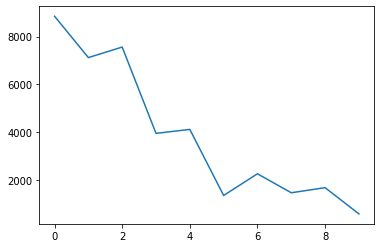

<All keys matched successfully>

In [24]:
best_loss = np.inf
loss_history = [] 
best_model_wts2 = copy.deepcopy(model2.state_dict())

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()
        print('shapes x y', x.shape, y.shape)
        # Pass in the two images into the network and obtain two outputs
        res = model2(x, y)
        print(res)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts2 = copy.deepcopy(model2.state_dict())

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model2.load_state_dict(best_model_wts2)


In [ ]:
matrix.flatten().shape

torch.Size([12])

### Model output check

the input


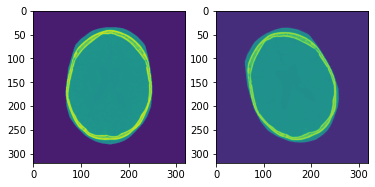

In [ ]:
#Printing the initial input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])





Let us compare label and output of the model (we will apply resulting natrix on x_input)


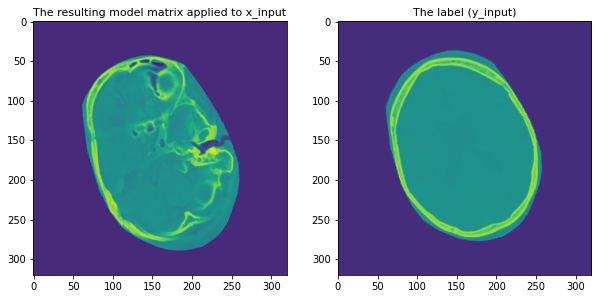

In [ ]:
print('the output of the model')
model2.load_state_dict(best_model_wts2)
matrix_output2 = model2(x, y)

matrix_output2 = matrix_output2.reshape(3,4)

mse=nn.MSELoss()
print(f'Final MSE error: {mse(matrix.flatten().reshape(3,4), matrix_output2)}')

matrix_output2 = matrix_output2.detach().numpy()
print('Let us compare label and output of the model (we will apply resulting natrix on x_input)')
fig = plt.subplots(1,2, figsize=(10, 5))
plt.subplot(1,2,1)
y_new2 = affine_transform(x_to_print, matrix_output2)
plt.title('The resulting model matrix applied to x_input',fontdict={'fontsize':11})
plt.imshow(y_new2[:,:,10])
plt.subplot(1,2,2)
plt.title('The label (y_input)', fontdict={'fontsize':11})
plt.imshow(y_to_print[:,:,10])
plt.show()

In [ ]:
tensor([[ 8.8575e-01,  3.6779e-01,  4.2519e-02, -4.9809e+01, -4.1023e-01,
          9.1739e-01, -2.8456e-02,  7.5187e+01, -1.7149e-02, -1.4251e-02,
          1.0263e+00,  1.9652e-02]], grad_fn=<AddmmBackward0>)